# Import Data sets

In [1]:
import pandas as pd
import numpy as np

def extract_G_m_from_data(filepath, customers=[3, 4]): #extracting data for clients 3 and 4 but in this case we only need 1 client data (client 3)
    # Load the data
    df = pd.read_csv(filepath)

    # Initialize a list to store the data matrices for each client set
    G_m = []

    for customer in customers:
        # Filter out the data for each client
        client_data = df[df['Customer'] == customer]

        # Drop non-consumption columns
        consumption_data = client_data.drop(columns=['Customer'])

        # Add the client's consumption data to the G_m list
        G_m.append(consumption_data.to_numpy())

    return G_m


filepath1 = 'first_10_clients_data-11-12-2d.csv' 
filepath2='first_10_clients_data-12-13-2d.csv'

G_m = extract_G_m_from_data(filepath1) #data of 2011-2012
g_DS=extract_G_m_from_data(filepath2) #data of 2012-2013


# 1 client 2D case (figure 2a)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cvxpy as cp
from joblib import Parallel, delayed

# Function to remove negative values from samples
def remove_negative_values(samples):
    samples = np.asarray(samples)
    samples[samples < 0] = 0
    return samples

# Utility functions
def u_m(x, W, g):
    return -np.linalg.norm((x + g) @ W, 1)

def u_fc(x, g):
    return -np.linalg.norm(np.sum(x + g, axis=0), np.inf)

def u_cvxpy(x, g):
    return -cp.norm(cp.sum(x + g, axis=0), 'inf')

def u_m_cvxpy(x, W, g):
    return -cp.norm((x + g) @ W, 1)

# Function to optimize the decision using cvxpy
def optimize_fc_decision(g, alpha, E_m, d, M, W):
    x = cp.Variable((M, d))
    g = np.array(g).reshape(M, d)
    
    objective = cp.Minimize(
        -cp.sum(cp.multiply(alpha, u_m_cvxpy(x, W, g))) - u_cvxpy(x, g)
    )
    
    constraints = [x >= 0, cp.sum(x) >= E_m]
    
    prob = cp.Problem(objective, constraints)
    
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status not in ["infeasible", "unbounded"]:
        return x.value
    else:
        raise ValueError("Optimization failed: " + prob.status)


def water_filling_matrix(matrix: np.ndarray, E_m: float) -> np.ndarray:
    """
    Perform a water-filling algorithm when alpha_m is set to zero.

    Parameters:
    matrix (np.ndarray): The input matrix of the data realizations g.
    E_m (float): Energy constraint.

    Returns:
    np.ndarray: A new matrix with the energy distributed x to maximze the FC's Utility.
    """
    matrix = np.array(matrix)
    num_rows, num_cols = matrix.shape
    new_matrix = np.zeros((num_rows, num_cols))
    
    for i in range(num_rows):
        vector = matrix[i, :]
        n = len(vector)
        highest_value = np.max(vector)
        shaded_area = np.sum([highest_value - v for v in vector])
        
        new_vector = np.zeros(n)
        
        if E_m <= shaded_area:
            remaining_energy = E_m
            sorted_indices = np.argsort(vector)
            cumulative_fill = 0

            for j in range(n):
                idx = sorted_indices[j]
                next_value = vector[sorted_indices[j + 1]] if j < n - 1 else highest_value
                increment = min(next_value - vector[idx], remaining_energy / (j + 1))
                new_vector[sorted_indices[:j + 1]] += increment
                remaining_energy -= increment * (j + 1)

                if remaining_energy <= 0:
                    break
        else:
            filled_vector = np.array([highest_value - v for v in vector])
            remaining_energy = E_m - np.sum(filled_vector)
            
            distributed_energy = remaining_energy / n
            new_vector = filled_vector + distributed_energy
        
        new_matrix[i, :] = new_vector
    
    return new_matrix



# Function to find the closest centroid
def closest_to_global_centrs(point, centroids):
    distances = np.linalg.norm(centroids - point, axis=1)
    closest_index = np.argmin(distances)
    return centroids[closest_index]

# Function to generate initial clusters using KMeans
def generate_initial_clusters(G_m, K):
    combined_data = np.vstack(G_m)
    combined_kmeans = KMeans(n_clusters=K).fit(combined_data)
    return combined_kmeans.labels_

# Function to calculate client centroids
def calculate_client_centroids(G_m, initial_clusters, K):
    client_centroids = []
    start_index = 0
    for client_data in G_m:
        client_length = len(client_data)
        client_labels = initial_clusters[start_index:start_index + client_length]
        start_index += client_length
        centroids = np.array([client_data[client_labels == k].mean(axis=0) if np.any(client_labels == k) else np.zeros(client_data.shape[1]) for k in range(K)])
        client_centroids.append(centroids)
    return client_centroids

# Function to generate ordered numbers between a and b with c values
def generate_ordered_numbers(a, b, c):
    if a > b:
        raise ValueError("The value of 'a' should be less than or equal to 'b'")
    
    if c < 1:
        raise ValueError("The value of 'c' should be at least 1")
    
    numbers = [0]
    remaining_count = c - 1
    
    if remaining_count > 0:
        random_numbers = np.linspace(a, b, remaining_count)
        numbers.extend(random_numbers)
    
    numbers = sorted(set(numbers))
    return numbers

# Function to generate R_k global
def generate_r_k_global(mn1, mn2, client_centroids, K, d):
    noise_z1 = np.random.normal((mn1, mn2), 0, (K, d)) #covariance m set to 0
    R_m = remove_negative_values(client_centroids[0] + noise_z1)
    return R_m

# Function to simulate expected utility over means
def simulate_expected_utility_over_means(mean1s, mean2s, W, alpha, E_m, d, c_centroids, g_DS, num_simulations=500, n_jobs=-1):
    expected_utilities_1 = np.zeros((len(mean1s), len(mean2s)))
    mean1s = np.asarray(mean1s)
    mean2s = np.asarray(mean2s)
    zero_index_1 = np.where(mean1s == 0)
    zero_index_2 = np.where(mean2s == 0)

    if zero_index_1[0].size == 0:
        raise ValueError("0 is not found in mean1s")
    if zero_index_2[0].size == 0:
        raise ValueError("0 is not found in mean2s")

    zero_index_1 = zero_index_1[0][0]
    zero_index_2 = zero_index_2[0][0]
 

    def simulate_one_point(mean1, mean2):
        utilities1 = []
        for _ in range(num_simulations):
            g_1 = g_DS[0][np.random.randint(g_DS[0].shape[0]), :]
            g = np.array([g_1])
            r_k_global = generate_r_k_global(mean1, mean2, c_centroids, K, d)
            closest_centroid = closest_to_global_centrs(g[0], r_k_global)
            optimized_x = water_filling_matrix(np.array([closest_centroid]), E_m)
            # optimized_x = optimize_fc_decision(closest_centroid, alpha, E_m, d, M, W)
            utility_1 = -u_m(optimized_x[0], W, g[0]) #costs of client
            utilities1.append(utility_1)

        mean_utilities = np.mean(utilities1)
        return mean_utilities,

    results = Parallel(n_jobs=n_jobs)(delayed(simulate_one_point)(mean1, mean2) for mean1 in mean1s for mean2 in mean2s)
    expected_utilities_1 = np.array([res[0] for res in results]).reshape(len(mean1s), len(mean2s))

    return expected_utilities_1, zero_index_1, zero_index_2

# Parameters and initial data
lower_bound = -3
upper_bound = 3
means1 = generate_ordered_numbers(lower_bound, upper_bound, 80)
means2 = generate_ordered_numbers(lower_bound, upper_bound, 80)
alpha = np.array([0.0])
E_m = 1.5 
d = 2 #number of dimensions
M = 1 #number of clients
K = 2 #number of clusters
D = np.array([[6, 0], [0, 0.1]])


initial_clusters = generate_initial_clusters(G_m, K)
client_centroids = calculate_client_centroids(G_m, initial_clusters, K)

expected_costs_1, zero_idx_1, zero_idx_2 = simulate_expected_utility_over_means(
    means1, means2, D, alpha, E_m, d, client_centroids, g_DS
)


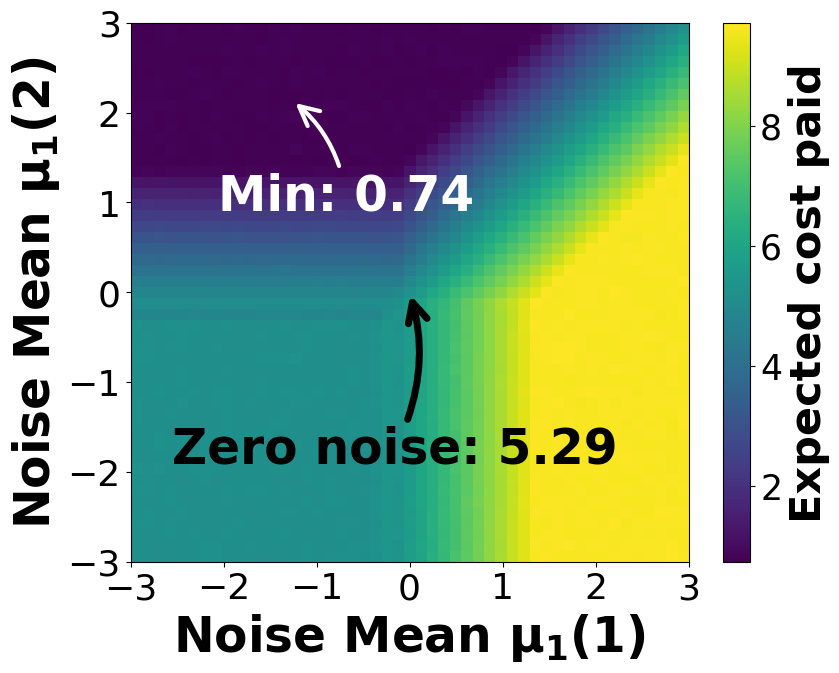

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(data, x_ticks, y_ticks, title, xlabel, ylabel):
    plt.figure(figsize=(9, 7))
    im = plt.imshow(data, cmap='viridis', interpolation='nearest', origin='lower',
                    extent=[x_ticks[0], x_ticks[-1], y_ticks[0], y_ticks[-1]], aspect='auto')

    # Create colorbar with larger font
    cbar = plt.colorbar(im)
    cbar.set_label('Expected cost paid', size=31, weight='bold')  # Adjust size as needed
    cbar.ax.tick_params(labelsize=25)  # Adjust tick size as needed

    # Set larger fonts for labels and title
    plt.xlabel(xlabel, fontsize=35, weight='bold')
    plt.ylabel(ylabel, fontsize=35, weight='bold')

    # Increase tick size
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)

    # Annotate with larger font and white arrow
    zero_index_x = np.argmin(np.abs(x_ticks))
    zero_index_y = np.argmin(np.abs(y_ticks))
    value_at_zero = data[zero_index_y, zero_index_x]
    plt.annotate(f'Zero noise: {value_at_zero:.2f}', xy=(0, 0), xytext=(150, -130),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black', linewidth=5),
                 ha='right', va='bottom', fontsize=35, color='black', weight='bold')

    min_value = np.min(data)
    min_index = np.unravel_index(np.argmin(data, axis=None), data.shape)
    min_x = x_ticks[min_index[1]]
    min_y = y_ticks[min_index[0]]

    plt.annotate(f'Min: {min_value:.2f}', xy=(min_x, min_y), xytext=(130, -85),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='white', linewidth=3),
                 ha='right', va='bottom', fontsize=35, color='white', weight='bold')

    plt.grid(False)
    plt.show()


plot_heatmap(expected_costs_1, means1, means2, title=r'Expected Cost Paid by Client ($\mathbf{-\mathbb{E}(u_1)}$)', xlabel=r'Noise Mean $\mathbf{\mu_1(1)}$', ylabel=r'Noise Mean $\mathbf{\mu_1(2)}$')


# Plotting feasible cost region (figure 2b)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cvxpy as cp
from joblib import Parallel, delayed


def remove_negative_values(samples):
    samples = np.asarray(samples)
    samples[samples < 0] = 0
    return samples


# Utility functions
def u_m(x, W, g):
    return -np.linalg.norm((x + g) @ W, 1)

def u_fc(x, g):
    return -np.linalg.norm(np.sum(x + g, axis=0), np.inf)

def u_cvxpy(x, g):
    return -cp.norm(cp.sum(x + g, axis=0), 'inf')

def u_m_cvxpy(x, W, g):
    return -cp.norm((x + g) @ W, 1)

# Function to optimize the decision using cvxpy
def optimize_fc_decision(g, alpha, E_m, d, M, W):
    x = cp.Variable((M, d))
    g = np.array(g).reshape(M, d)
    
    objective = cp.Minimize(
        -cp.sum(cp.multiply(alpha, u_m_cvxpy(x, W, g))) - u_cvxpy(x, g)
    )
    
    constraints = [x >= 0, cp.sum(x, axis=1) >= E_m]
    
    prob = cp.Problem(objective, constraints)
    
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status not in ["infeasible", "unbounded"]:
        return x.value
    else:
        raise ValueError("Optimization failed: " + prob.status)

def closest_to_global_centrs(point, centroids):
    distances = np.linalg.norm(centroids - point, axis=1)
    closest_index = np.argmin(distances)
    return centroids[closest_index]

def generate_initial_clusters(G_m):
    combined_data = np.vstack(G_m)
    combined_kmeans = KMeans(n_clusters=K).fit(combined_data)
    return combined_kmeans.labels_

def calculate_client_centroids(G_m, initial_clusters, K):
    client_centroids = []
    start_index = 0
    for client_data in G_m:
        client_length = len(client_data)
        client_labels = initial_clusters[start_index:start_index + client_length]
        start_index += client_length
        centroids = np.array([client_data[client_labels == k].mean(axis=0) if np.any(client_labels == k) else np.zeros(client_data.shape[1]) for k in range(K)])
        client_centroids.append(centroids)
    return client_centroids

def generate_ordered_numbers(a, b, c):
    if a > b:
        raise ValueError("The value of 'a' should be less than or equal to 'b'")
    
    if c < 1:
        raise ValueError("The value of 'c' should be at least 1")
    
    numbers = [0]
    remaining_count = c - 1
    
    if remaining_count > 0:
        random_numbers = np.linspace(a, b, remaining_count)
        numbers.extend(random_numbers)
    
    numbers = sorted(set(numbers))
    
    return numbers

def generate_r_k_global(mn1, mn2, client_centroids):
    noise_z1 = np.random.normal((mn1, mn2), 0, (K, d))
    R_m = remove_negative_values(client_centroids[0] + noise_z1)
    return R_m

def simulate_expected_utility_over_means(mean1s, mean2s, W,alpha, E_m, d, c_centroids, num_simulations=500, n_jobs=-1):
    expected_utilities_1 = np.zeros((len(mean1s), len(mean2s)))
    expected_utilities_2 = np.zeros((len(mean1s), len(mean2s)))

    mean1s = np.asarray(mean1s)
    mean2s = np.asarray(mean2s)
    zero_index_1 = np.where(mean1s == 0)
    zero_index_2 = np.where(mean2s == 0)
    
    if zero_index_1[0].size == 0:
        raise ValueError("0 is not found in mean1s")
    if zero_index_2[0].size == 0:
        raise ValueError("0 is not found in mean2s")

    zero_index_1 = zero_index_1[0][0]
    zero_index_2 = zero_index_2[0][0]


    def simulate_one_point(mean1, mean2):
        utilities1 = []
        utilities2 = []
        for _ in range(num_simulations):
            g_1 = g_DS[0][np.random.randint(g_DS[0].shape[0]), :]
            g = np.array([g_1])
            r_k_global = generate_r_k_global(mean1, mean2, c_centroids)
            closest_centroid = closest_to_global_centrs(g[0], r_k_global)
            optimized_x = water_filling_matrix(np.array([closest_centroid]), E_m)
            # optimized_x = optimize_fc_decision(closest_centroid, alpha, E_m, d, M, W)
            utility_1 = -u_m(optimized_x[0], W, g[0]) #cost of client
            utility_2 = -u_fc(optimized_x, closest_centroid) #cost of FC
            utilities1.append(utility_1)
            utilities2.append(utility_2)

        mean_utilities = np.mean(utilities1), np.mean(utilities2)
        return mean_utilities

    results = Parallel(n_jobs=n_jobs)(delayed(simulate_one_point)(mean1, mean2) for mean1 in mean1s for mean2 in mean2s)
    results = np.array([res for res in results]).reshape(len(mean1s), len(mean2s), 2)
    expected_utilities_1, expected_utilities_2 = results[:, :, 0], results[:, :, 1]

    return expected_utilities_1, expected_utilities_2, zero_index_1, zero_index_2


lower_bound = -3
upper_bound = 3
means1 = generate_ordered_numbers(lower_bound, upper_bound, 83)
means2 = generate_ordered_numbers(lower_bound, upper_bound, 83)
alpha = np.array([0.0])
E_m = 1.5

d = 2 #number of dimensions
M = 1 #number of clients
K = 2 #number of clusters



D=np.array([[6, 0], [0, 0.1]])

initial_clusters = generate_initial_clusters(G_m)
client_centroids = calculate_client_centroids(G_m, initial_clusters, K)

expected_costs_1, expected_costs_2, zero_idx_1, zero_idx_2 = simulate_expected_utility_over_means(
    means1, means2,D, alpha, E_m, d, client_centroids
)



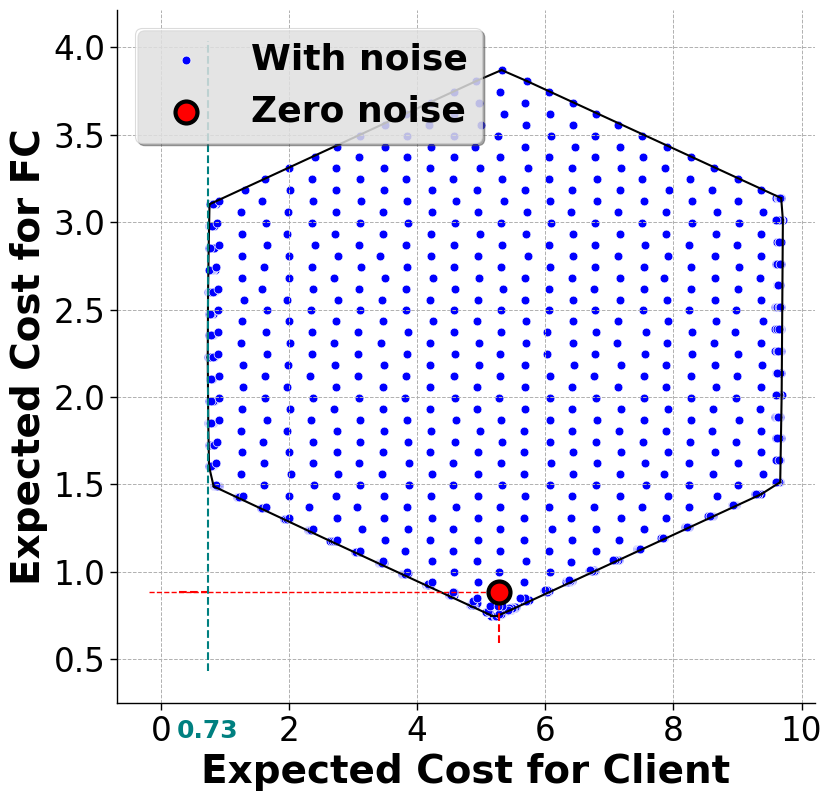

In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

sns.set_context(context="paper", font_scale=2.5)

def plot_expected_utilities(expected_costs_1, expected_costs_2, zero_idx_1, zero_idx_2):
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(9, 9))
    
    # Plot all points with smaller markers
    points = np.column_stack((expected_costs_1.flatten(), expected_costs_2.flatten()))
    most_west_x = np.min(points[:, 0])

    sns.scatterplot(x=points[:, 0], y=points[:, 1], 
                    label='With noise', color='blue', alpha=1, edgecolor='w', s=40, ax=ax)
    
    # Highlight the point where both means are zero with a larger marker
    zero_x = expected_costs_1[zero_idx_1, zero_idx_2]
    zero_y = expected_costs_2[zero_idx_1, zero_idx_2]
    sns.scatterplot(x=[zero_x], y=[zero_y], color='red', label='Zero noise', edgecolor='black', s=250, zorder=15, marker='o', linewidth=3, ax=ax)
    
    # Highlight the feasible region boundary using Convex Hull
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-', lw=1.5)
    
    # Add red dotted lines from the zero noise point to the left and bottom axes
    ax.plot([zero_x, zero_x], [ax.get_ylim()[0], zero_y], color='red', linestyle='--', linewidth=1.5)
    ax.plot([ax.get_xlim()[0], most_west_x], [zero_y, zero_y], color='red', linestyle='--', linewidth=1.5)
    
    # Add red dotted line to the west of the red dot to the y-axis
    ax.plot([ax.get_xlim()[0], zero_x], [zero_y, zero_y], color='red', linestyle='--', linewidth=1)
    
    # Add teal vertical line showing the most west side of the figure
    ax.plot([most_west_x, most_west_x], [ax.get_ylim()[0], ax.get_ylim()[1]], color='teal', linestyle='--', linewidth=1.5)
    # ax.text(0, ax.get_ylim()[0] + 0.01, f'{0.72:.2f}', color='teal', ha='center', fontsize=20)
    ax.text(most_west_x, ax.get_ylim()[0] - 0.2, f'{most_west_x:.2f}', color='teal', ha='center', fontsize=18, weight='bold')

    # Setting axis labels with increased font size
    ax.set_xlabel('Expected Cost for Client', fontsize=28, weight='bold')
    ax.set_ylabel('Expected Cost for FC', fontsize=28, weight='bold')
    
    # Customizing legend with transparency
    ax.legend(fontsize=24, frameon=True, shadow=True, prop={'weight': 'bold', 'size': 26}, loc='upper left', framealpha=0.7)

    # Ticks parameters
    ax.tick_params(axis='both', which='major', labelsize=23.5)  # Increase label size here
    
    # Add grid with customized properties
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)
    
    # Remove the top and right spines
    sns.despine()
    
    # Show the plot
    plt.show()

plot_expected_utilities(expected_costs_1, expected_costs_2, zero_idx_1, zero_idx_2)
